# Physics NeMo External Aerodynamics DLI

## Notebook 1 - Preprocessing Ahmed body *surface* dataset

### Introduction


For educational purposes, it's important to use lightweight datasets that are easy to store and manage, especially for users who may not have access to high-performance computing resources. One such dataset is the **Ahmed body surface data**, which includes 3D surface geometry, pressure and wall shear stress data for variations in the Ahmed body geometry and inlet Reynolds number. This dataset is a great choice because it is relatively small in size, yet provides valuable information about aerodynamic simulations. It’s ideal for teaching and experimentation, as it won’t demand excessive storage or computational power. *Note that this dataset was created by the NVIDIA PhysicsNeMo development team and differs from other similar datasets hosted on cloud platforms like AWS.*

In this notebook, we will walk through the preprocessing steps required to prepare the **Ahmed body surface dataset** for training with the **DoMINO model**, to predict surface quantities like pressure and wall shear stress. The DoMINO model requires 3D surface geometry in **STL format**. The **STL (Stereolithography)** format is a widely used file format for representing 3D surface geometry in computer-aided design (CAD) applications. It describes the surface of a 3D object using a collection of triangular facets, making it a common format for 3D printing and computational geometry. So, as the first step, we’ll extract the 3D surface geometry from the **VTP files**. These files are commonly used in the **VTK (Visualization Toolkit)** format, which stores surface data as **PolyData**—a structure that represents points, lines, and polygons on the surface.

To make the dataset more suitable for machine learning, we will convert the **VTP (VTK PolyData)** format into **NPY (NumPy)** format. This conversion makes the data easier to work with in machine learning workflows, as NumPy arrays are optimized for numerical operations, making computations faster and more efficient. After converting the data into NPY format, it can be stored on disk, where it will be readily accessible for training the model and further analysis.

Key aspects of this training:
- Understanding the Ahmed body geometry and its aerodynamic characteristics
- Processing CFD mesh data for deep learning applications

## Table of Contents
- [Step 1: Define Experiment Parameters and Dependencies](#step-1-define-experiment-parameters-and-dependencies)
  - [Loading Required Libraries](#loading-required-libraries)
  - [Dependencies](#dependencies)
  - [Experiment Parameters and Variables](#experiment-parameters-and-variables)
- [Step 2: Convert VTK to STL Files](#step-2-convert-vtk-to-stl-files)
  - [Understanding the Conversion Process](#understanding-the-conversion-process)
  - [Key Components and Libraries](#key-components-and-libraries)
  - [Important Considerations](#important-considerations)
  - [Implementation Overview](#implementation-overview)

### **Step 1: Define Experiment Parameters and Dependencies**

The first step in training the DoMINO model on the Ahmed body surface dataset is to set up our experiment environment and define the necessary parameters. This includes specifying paths to our data, configuring training settings, and ensuring all required libraries are available.

Key components we need to set up:
- Data paths for training and validation sets
- Model hyperparameters and training configurations
- Visualization settings for results
- Required Python libraries for mesh processing and deep learning

### Loading Required Libraries

Before we proceed with the experiment setup, let's first import all the necessary libraries. These libraries will be used for:
- Mesh processing and visualization (`vtk`, `pyvista`)
- Data handling and file operations (`pathlib`, `concurrent.futures`)
- Progress tracking and visualization (`tqdm`, `matplotlib`)
- PyTorch provides data primitives: `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels.
- Important utilities for data processing and training, testing DoMINO (`modulus.utils.domino.utils`)

### Dependencies
Ensure that the required Python libraries are installed:

```bash
pip install numpy pyvista vtk matplotlib tqdm numpy-stl
apt install  xvfb
```

In [2]:
import os
import random
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from typing import Union

import numpy as np
import pyvista as pv
import vtk
from stl import mesh
from tqdm import tqdm

from physicsnemo.utils.domino.utils import *
from torch.utils.data import Dataset

### Experiment Parameters and Variables

In this section, we set up all the essential parameters and variables required for the Ahmed body experiment. 
**Before proceeding, navigate to the data directory and extract the `ahmed_body.tar.xz` archive. This file contains several sample `.vtp` files needed to run the scripts in this notebook and others.**

In [3]:
# Directory and Path Configuration
DATA_DIR = Path("./ahmed_body_dataset")  # Root directory for dataset

# Physical Variables
VOLUME_VARS = ["p"]  # Volume variables to predict (pressure)
SURFACE_VARS = ["p", "wallShearStress"]  # Surface variables to predict
AIR_DENSITY = 1.205  # Air density in kg/m³

### **Step 2: Convert VTK to STL Files**

The second step in our workflow involves converting the CFD simulation data from VTK format to STL format.

#### Understanding the Conversion Process

The conversion from VTK to STL involves several key steps:
1. Reading the VTK PolyData file using specialized readers
2. Extracting the surface geometry and mesh data
3. Converting the data while preserving topology and surface properties
4. Saving the result in binary STL format

#### Key Components and Libraries

We'll use the following libraries for this conversion:

1. **VTK (Visualization Toolkit)**
   - `vtk`: Reads VTK PolyData files (.vtp)
   - `vtkSTLWriter`: Writes data in STL format
   - `vtkPolyData`: Manages surface mesh data structures

2. **File System Operations**
   - `os.path`: Handles file paths and directory operations
   - `pathlib.Path`: Provides modern path handling capabilities

#### Important Considerations

During the conversion process, we need to ensure:
- Surface normal vectors are preserved correctly
- Mesh quality and topology are maintained
- The output is compatible with the DoMINO model's requirements
- Memory is managed efficiently for large datasets

#### Implementation Overview

The conversion is implemented through two main functions:

1. **Environment Setup**
```python
def setup_environment(data_dir: str):
    """Sets up the working directory and returns relevant paths."""
    # Returns paths for dataset, info files, STL files, and surface data
```

2. **VTK to STL Conversion**
```python
def convert_vtk_to_stl(vtk_filename: str, stl_filename: str):
    """Converts a single .vtp file to .stl format."""
    # Uses vtkXMLPolyDataReader and vtkSTLWriter for conversion
```

Let's proceed with implementing these functions and performing the conversion:

In [4]:
def setup_environment(data_dir: str):
    """Sets up the working directory and returns relevant paths."""
    print("=== Environment Setup ===")
    print(f"Current data directory: {data_dir}")

    dataset_paths = {split: os.path.join(data_dir, split) for split in ["train", "validation", "test"]}
    info_paths = {k: os.path.join(data_dir, f"{k}_info") for k in dataset_paths}
    stl_paths = {k: os.path.join(data_dir, f"{k}_stl_files") for k in dataset_paths}
    surface_paths = {k: os.path.join(data_dir, f"{k}_prepared_surface_data") for k in dataset_paths}

    return dataset_paths, info_paths, stl_paths, surface_paths


def convert_vtk_to_stl(vtk_filename: str, stl_filename: str):
    """Converts a single .vtp file to .stl format."""
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(vtk_filename)
    reader.Update()

    if not reader.GetOutput():
        print(f"[ERROR] Failed to read {vtk_filename}")
        return

    writer = vtk.vtkSTLWriter()
    writer.SetFileName(stl_filename)
    writer.SetInputConnection(reader.GetOutputPort())
    writer.Write()

    del reader, writer  # Free memory


def process_file(vtp_file: str, output_path: str):
    """Processes a single .vtp file and saves it as .stl."""
    output_file = os.path.join(output_path, os.path.basename(vtp_file).replace(".vtp", ".stl"))
    convert_vtk_to_stl(vtp_file, output_file)


def convert_vtp_to_stl_batch(dataset_paths: dict, stl_paths: dict):
    """Processes all .vtp files in dataset_paths and saves them in output_paths."""
    print("\n=== Starting Conversion Process ===")

    for path in stl_paths.values(): os.makedirs(path, exist_ok=True)

    for key, dataset_path in dataset_paths.items():
        stl_path = stl_paths[key]
        vtp_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.vtp')]

        if not vtp_files:
            print(f"[WARNING] No .vtp files found in {dataset_path}")
            continue

        print(f"\nProcessing {len(vtp_files)} files from {dataset_path} → {stl_path}...")

        with ProcessPoolExecutor() as executor:
            list(tqdm(executor.map(process_file, vtp_files, [stl_path] * len(vtp_files)), 
                      total=len(vtp_files), desc=f"Converting {key}", dynamic_ncols=True))

    print("=== All Conversions Completed Successfully ===")


Lets convert the files:

In [5]:
dataset_paths, info_paths, stl_paths, surface_paths = setup_environment(DATA_DIR)
convert_vtp_to_stl_batch(dataset_paths, stl_paths)

=== Environment Setup ===
Current data directory: ../ahmed_body_dataset

=== Starting Conversion Process ===

Processing 408 files from ../ahmed_body_dataset/train → ../ahmed_body_dataset/train_stl_files...


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1296) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
Converting train: 100%|█████████████████████████████████████████████████████| 408/408 [00:20<00:00, 20.06it/s]


Processing 50 files from ../ahmed_body_dataset/validation → ../ahmed_body_dataset/validation_stl_files...



Converting validation: 100%|██████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.98it/s]


Processing 50 files from ../ahmed_body_dataset/test → ../ahmed_body_dataset/test_stl_files...



Converting test: 100%|████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.24it/s]

=== All Conversions Completed Successfully ===


### **Step 3: Visualizing STL Meshes**

The third step in our workflow focuses on visualizing the converted STL meshes to verify the success of our conversion process. This step is crucial because:

#### Understanding the Visualization Process

The visualization of STL meshes involves several key aspects:
1. Loading the STL files using appropriate visualization libraries
2. Setting up the visualization environment with proper parameters
3. Rendering the mesh with appropriate colors and properties
4. Providing interactive controls for inspection

#### Key Components and Libraries

We'll use the following libraries for visualization:

1. **PyVista**
   - `pv.read()`: Loads STL files
   - `pv.Plotter()`: Creates interactive visualization windows
   - `pv.wrap()`: Converts VTK objects to PyVista meshes

2. **Matplotlib**
   - For static 2D visualizations if needed
   - For saving visualization outputs

#### Important Visualization Parameters

During the visualization process, we need to consider:
- Mesh surface properties (color, opacity)
- Camera position and orientation
- Lighting conditions
- Interactive controls for rotation and zoom
- Quality of the rendered output

#### Implementation Overview

The visualization is implemented through several key functions:

1. **Mesh Loading**
```python
def load_stl_mesh(file_path: str):
    """Loads an STL file and returns a PyVista mesh object."""
    # Uses PyVista to read and process the STL file
```

2. **Interactive Visualization**
```python
def plot_stl_comparison(mesh1, mesh2, title1="Case 3", title2="Case 9", volume1=None, volume2=None):
    """Create a multi-view comparison visualization of two STL meshes."""
    # Sets up the plotter and displays the meshes
```

Let's proceed with implementing these functions and visualizing our converted meshes:

In [6]:
def load_stl(stl_path: str):
    """Load an STL file and return its PyVista mesh."""
    stl_file = Path(stl_path)
    if not stl_file.exists():
        print(f"[ERROR] STL file not found: {stl_path}")
        return None
    
    try:
        mesh = pv.read(str(stl_file))
        return mesh
    except Exception as e:
        print(f"[ERROR] Failed to load STL file: {e}")
        return None

def load_stl(stl_path: str):
    """Load an STL file and return its PyVista mesh."""
    stl_file = Path(stl_path)
    if not stl_file.exists():
        print(f"[ERROR] STL file not found: {stl_path}")
        return None
    
    try:
        mesh = pv.read(str(stl_file))
        return mesh
    except Exception as e:
        print(f"[ERROR] Failed to load STL file: {e}")
        return None

def plot_stl_comparison(mesh1, mesh2, title1="Case 3", title2="Case 9"):
    """Create a multi-view comparison visualization of two STL meshes."""
    # Start virtual frame buffer
    pv.start_xvfb()
    
    # Create plotter with off-screen rendering
    pl = pv.Plotter(shape=(2, 4), window_size=[1600, 800], off_screen=True)
    
    
    # Display parameters for each case with brighter colors
    params_case1 = {
        "show_edges": True,
        "opacity": 1.0,
        "edge_color": 'black',
        "line_width": 0.5,
        "color": [0.6, 0.8, 1.0],
        "smooth_shading": True,
        "specular": 0.4,
        "specular_power": 10,
        "diffuse": 0.9,
        "ambient": 1.0, 
    }
        
    params_case2 = {
        "show_edges": True,
        "opacity": 1.0,
        "edge_color": 'black',
        "line_width": 0.5,
        "color": [0.7, 1.0, 0.7], 
        "smooth_shading": True,
        "specular": 0.4,
        "specular_power": 10,
        "diffuse": 0.9,
        "ambient": 1.0, 
    }

    def setup_view(pl, mesh, title, view_type, params):
        """Helper function to set up consistent views"""
        pl.add_mesh(mesh, **params)
        pl.add_text(title, position="upper_edge", font_size=10, color='black')
        pl.add_axes(line_width=2)
        
        if view_type == "xy":
            pl.view_xy()
        elif view_type == "xz":
            pl.view_xz()
        elif view_type == "yz":
            pl.view_yz()
        else:  # isometric
            pl.view_isometric()
        
        pl.reset_camera()
        pl.camera.zoom(0.85)
        # Add directional lighting
    
    # Plot views for both meshes
    views = [("xy", "Top"), ("xz", "Front"), ("yz", "Side"), ("isometric", "Isometric")]
    
    # First mesh (top row)
    for col, (view_type, view_name) in enumerate(views):
        pl.subplot(0, col)
        setup_view(pl, mesh1, f"{title1} - {view_name}", view_type, params_case1)

    # Second mesh (bottom row)
    for col, (view_type, view_name) in enumerate(views):
        pl.subplot(1, col)
        setup_view(pl, mesh2, f"{title2} - {view_name}", view_type, params_case2)

    pl.background_color = '#f0f0f0'
    
    # Display in notebook
    return pl.show(jupyter_backend='static')

Lets plot two geometries:


=== STL File Comparison ===

File: case102.stl vs case116.stl
Number of Faces: 153241 vs 115391
Surface Area: 0.93 vs 0.68
Volume: 0.070 vs 0.049 m³


/usr/local/lib/python3.12/dist-packages/pyvista/core/pointset.py:1365: PyVistaDeprecationWarning: The current behavior of `pv.PolyData.n_faces` has been deprecated.
                Use `pv.PolyData.n_cells` or `pv.PolyData.n_faces_strict` instead.
                See the documentation in '`pv.PolyData.n_faces` for more information.
  warnings.warn(
error: XDG_RUNTIME_DIR is invalid or not set in the environment.


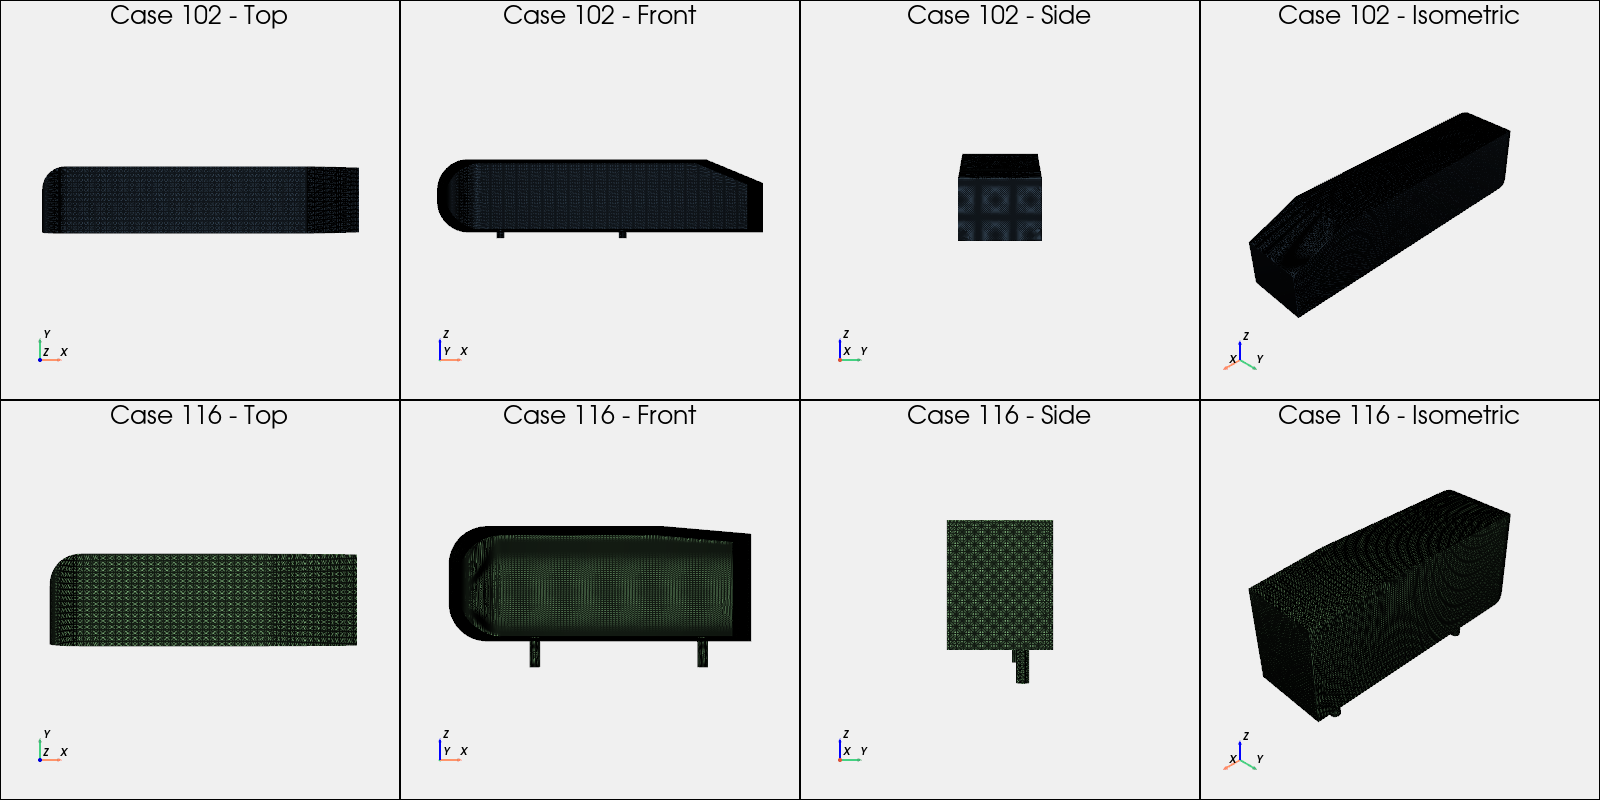

In [8]:
# Define STL file paths
STL_FILE_1 = Path("./ahmed_body_dataset/train_stl_files/case102.stl")
STL_FILE_2 = Path("./ahmed_body_dataset/train_stl_files/case116.stl")

# Load STL files
mesh1 = load_stl(STL_FILE_1)
mesh2 = load_stl(STL_FILE_2)

# Print comparison
print("\n=== STL File Comparison ===\n")
print(f"File: {STL_FILE_1.name} vs {STL_FILE_2.name}")
print(f"Number of Faces: {mesh1.n_faces} vs {mesh2.n_faces}")
print(f"Surface Area: {mesh1.area:.2f} vs {mesh2.area:.2f}")
print(f"Volume: {mesh1.volume:.3f} vs {mesh2.volume:.3f} m³")

# Create visualization with volumes included
plot_stl_comparison(mesh1, mesh2, title1="Case 102", title2="Case 116")

### **Step 4: Convert CFD Results to NPY Format**

The fourth step in our workflow focuses on converting CFD simulation results into NumPy (.npy) format for efficient training. As previously mentioned, the advantages of using the NPY format include:
- NPY format provides faster data loading during training
- Enables efficient memory management for large datasets
- Facilitates parallel processing of simulation data
- Optimizes data access patterns for deep learning frameworks

#### Understanding the Conversion Process

The conversion process involves several key aspects:
1. Reading CFD simulation data from VTK files
2. Extracting surface and volume variables
3. Processing mesh geometry and physical quantities
4. Normalizing data using appropriate scaling factors
5. Saving processed data in NPY format

#### Key Components and Libraries

We'll use the following libraries for the conversion:

1. **VTK and PyVista**
   - For reading CFD simulation data
   - For processing mesh geometry and surface properties
   - For computing cell sizes and normals

2. **NumPy**
   - For efficient array operations
   - For saving data in NPY format

3. **Concurrent Processing**
   - For parallel processing of multiple files
   - For improved conversion speed

#### Important Data Processing Parameters

During the conversion process, we need to consider:
- Surface variables (pressure, wall shear stress)
- Mean variables (mean wall shear stress, mean pressure)
- Data normalization using inlet velocity and density. **The inlet velocity will be read from the info files**
  ```python
          with open(info_path, "r") as file:
            velocity = next(float(line.split(":")[1].strip()) for line in file if "Velocity" in line)
  ```
- Mesh geometry preservation
- Memory efficiency for large datasets

#### Implementation Overview

The conversion is implemented through several key components:

1. **Dataset Class**
```python
class OpenFoamAhmedBodySurfaceDataset(Dataset):
    """Datapipe for converting OpenFOAM dataset to npy."""
    # Handles data loading and processing
```

2. **File Processing Functions**
```python
def process_file(fname: str, fm_data, output_path: str):
    """Processes a single surface data file."""
    # Converts individual files to NPY format
```

3. **Batch Processing**
```python
def process_surface_data_batch(dataset_paths, info_paths, stl_paths, surface_paths):
    """Processes all surface data files in parallel."""
    # Handles parallel processing of multiple files
```

Let's proceed with implementing these components and converting our CFD results:

In [9]:
class OpenFoamAhmedBodySurfaceDataset(Dataset):
    """Datapipe for converting OpenFOAM dataset to npy."""

    def __init__(self, data_path: Union[str, Path], info_path: Union[str, Path], stl_path: Union[str, Path], surface_variables=None, volume_variables=None, device: int = 0):
        self.data_path = Path(data_path).expanduser()
        self.stl_path = Path(stl_path).expanduser()
        self.info_path = Path(info_path).expanduser()
        assert self.data_path.exists(), f"Path {self.data_path} does not exist"
        
        self.filenames = get_filenames(self.data_path)
        random.shuffle(self.filenames)
        self.surface_variables = surface_variables or ["p", "wallShearStress"]
        self.volume_variables = volume_variables or ["UMean", "pMean"]
        self.device = device

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        cfd_filename = self.filenames[idx]
        car_dir = self.data_path / cfd_filename

        stl_path = self.stl_path / f"{car_dir.stem}.stl"
        info_path = self.info_path / f"{car_dir.stem}_info.txt"

        with open(info_path, "r") as file:
            velocity = next(float(line.split(":")[1].strip()) for line in file if "Velocity" in line)

        mesh_stl = pv.get_reader(stl_path).read()
        stl_faces = mesh_stl.faces.reshape(-1, 4)[:, 1:]
        stl_sizes = np.array(mesh_stl.compute_cell_sizes(length=False, area=True, volume=False).cell_data["Area"])

        reader = vtk.vtkXMLPolyDataReader()
        reader.SetFileName(str(car_dir))
        reader.Update()
        polydata = reader.GetOutput()
        
        celldata = get_node_to_elem(polydata).GetCellData()
        surface_fields = np.concatenate(get_fields(celldata, self.surface_variables), axis=-1) / (AIR_DENSITY * velocity**2)

        mesh = pv.PolyData(polydata)
        surface_sizes = np.array(mesh.compute_cell_sizes(length=False, area=True, volume=False).cell_data["Area"])
        surface_normals = mesh.cell_normals / np.linalg.norm(mesh.cell_normals, axis=1)[:, np.newaxis]

        return {
            "stl_coordinates": mesh_stl.points.astype(np.float32),
            "stl_centers": mesh_stl.cell_centers().points.astype(np.float32),
            "stl_faces": stl_faces.flatten().astype(np.float32),
            "stl_areas": stl_sizes.astype(np.float32),
            "surface_mesh_centers": mesh.cell_centers().points.astype(np.float32),
            "surface_normals": surface_normals.astype(np.float32),
            "surface_areas": surface_sizes.astype(np.float32),
            "volume_fields": None,
            "volume_mesh_centers": None,
            "surface_fields": surface_fields.astype(np.float32),
            "filename": cfd_filename,
            "stream_velocity": velocity,
            "air_density": AIR_DENSITY,
        }

def process_file(fname: str, fm_data, output_path: str):
    """Processes a single surface data file."""
    full_path, output_file = os.path.join(fm_data.data_path, fname), os.path.join(output_path, f"{fname}.npy")
    if os.path.exists(output_file) or not os.path.exists(full_path) or os.path.getsize(full_path) == 0:
        return
    np.save(output_file, fm_data[fm_data.filenames.index(fname)])

def process_surface_data_batch(dataset_paths: dict, info_paths: dict, stl_paths: dict, surface_paths: dict):
    """Processes all surface data files in dataset_paths and saves them in output_paths."""

    for path in surface_paths.values(): os.makedirs(path, exist_ok=True)

    print("=== Starting Processing ===")
    for key, dataset_path in dataset_paths.items():
        surface_path = surface_paths[key]
        os.makedirs(surface_path, exist_ok=True)
        fm_data = OpenFoamAhmedBodySurfaceDataset(dataset_path, info_paths[key], stl_paths[key], VOLUME_VARS, SURFACE_VARS)
        file_list = [fname for fname in fm_data.filenames if fname.endswith(".vtp")]
        
        print(f"\nProcessing {len(file_list)} files from {dataset_path} → {surface_path}...")
        
        with ProcessPoolExecutor() as executor:
            list(tqdm(executor.map(process_file, file_list, [fm_data]*len(file_list), [surface_path]*len(file_list)),
                      total=len(file_list), desc=f"Processing {key}", dynamic_ncols=True))
        
    print("=== All Processing Completed Successfully ===")


Lets convert the files:

In [10]:
process_surface_data_batch(dataset_paths, info_paths, stl_paths, surface_paths)

=== Starting Processing ===

Processing 408 files from ../ahmed_body_dataset/train → ../ahmed_body_dataset/train_prepared_surface_data...


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1296) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
Processing train: 100%|██████████████████████████████████████████████████| 408/408 [00:00<00:00, 14319.46it/s]


Processing 50 files from ../ahmed_body_dataset/validation → ../ahmed_body_dataset/validation_prepared_surface_data...



Processing validation: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 12076.89it/s]


Processing 50 files from ../ahmed_body_dataset/test → ../ahmed_body_dataset/test_prepared_surface_data...



Processing test: 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 14157.51it/s]

=== All Processing Completed Successfully ===
